<a href="https://colab.research.google.com/github/kamalchapagain/M5-Forecasting/blob/master/Sampled_M5_Sep27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
#just testing the gpu
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Summary of this program

**This program consist main 6 parts**

*Part 1 : Description of datasets*

*Part 2 : Downcastling of data*
            - reduced the memory size
            - and combining datasets

*Part 3 : Sampling of datasets (sales and prices datasets)
            - only 10% of dataset is taken due to the computational limitations.*

*Part 4 : Etraploatory Data Aanalysis*
            - Item price
            - Item sold
            - Statewise analysis

*Part 5 : Feature Engineering*
            - Label encoding
            - Introducing lags
            - Mean encoding
            - Rolling window substitution
            - trend

*Part 6 : Modeling and Estimation*
            - Implementations of LGBM model

*Part 7 : Forecasting and submission*

In [164]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.10.0)


In [165]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

In [166]:
gc.collect()

9155

In [167]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [269]:
#Fetch the dataset
path='/content/drive/My Drive/GoogleColab/'
sales = pd.read_csv(path+'sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv(path+'calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv(path+'sell_prices.csv')
prices.name = 'prices'

#Part 1. Introduction of datasets

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded=files.upload()

Saving DatasetInfo.png to DatasetInfo.png


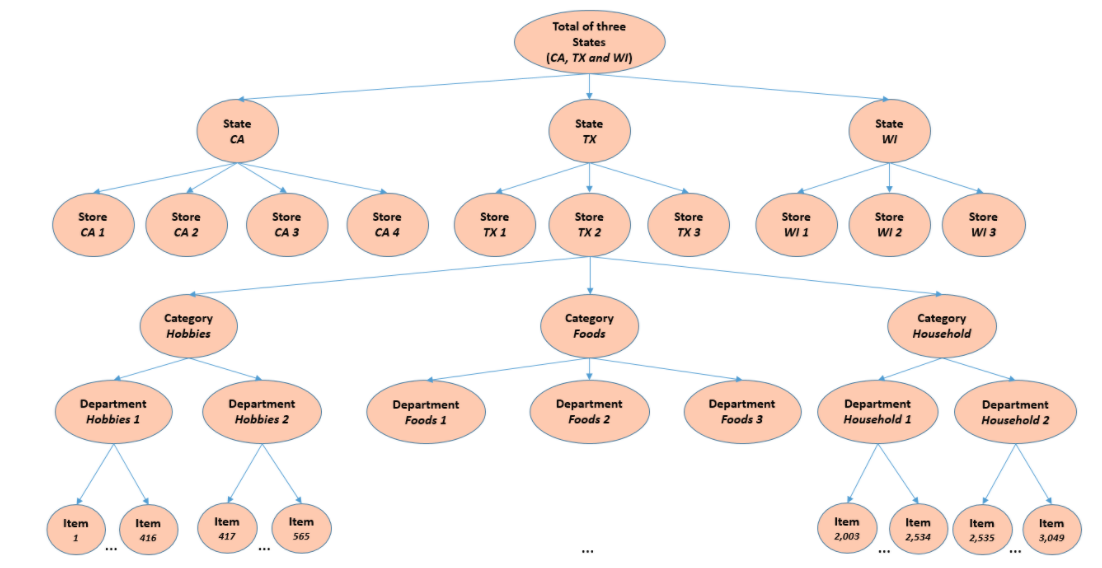

In [ ]:
Image('DatasetInfo.png', width=1200)

# 1.1 Train-Validation-Test split Strategy

- **In the first phase of M5-Forecasting dataset:** 

- *Training dataset (X_train): 2011-01-29(d_1) to 2016-03-17 (d_1885)* 

- *Validation dataset (X_val): d_1886 to d_1913 (28 days)*

- *Test dataset for evaluation (X_test): d_1914 to d_1941 (28 days)*

- *and corresponding days is taken for y_train (d_1- d_1885) and y_val (d_1886-d_1913)*

- *y_test (d_1914 to d1941) for 28 days is need to forecast and submit*

- **However, y_test dataset of first phase(d_1914 to d_1941) is already released for the second phase, therefore, we can modified the training/validation/testing dataset as,**

- *Training dataset (X_train): d_1 to d_1913)* 

- *Validation dataset (X_val): d_1914 to d_1941 (28 days)*

- *Test dataset for evaluation (X_test): d_1941 to d_1969 (28 days)*

- *and corresponding days is taken for y_train (d_1- d_1913) and y_val (d_1914-d_1941)*


In [270]:
print(sales.shape, prices.shape, calendar.shape)

(30490, 1947) (6841121, 4) (1969, 14)


In [271]:
#Add zero sales for the remaining days 1942-1969 (where we are going to forecast)
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

# Part 2. Downscatling of data

In [272]:
#Lets save the memory,
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [273]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [274]:
dic = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd],
       'After downcasting':[sales_ad,calendar_ad,prices_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

***Size of memory is almost reduced by 1/4th. However, we still need losts of RAM utilization because of several thousands rows and many columns. Due to the computional limitations of notebook we are going to sample the dataset.***

# part 3. Reduction of dataset: using sampling technique

In [275]:
from sklearn.model_selection import train_test_split
prices_keep, prices_discard=train_test_split(prices,train_size=0.1, random_state=42)
print(prices.shape, prices_keep.shape)

(6841121, 4) (684112, 4)


In [276]:
sales_keep, sales_discard=train_test_split(sales,train_size=0.1, random_state=42)
print(sales.shape, sales_keep.shape)

(30490, 1975) (3049, 1975)


In [277]:
#arraning in proper order
sales_keep.sort_index(inplace=True)
sales_keep.reset_index(drop=True)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_012_CA_1_evaluation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,0,2,0,0,0,0,0,2,0,0,0,2,0,0,0,2,0,3,0,1,1,3,1,1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_014_CA_1_evaluation,HOBBIES_1_014,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,1,1,1,0,2,2,1,1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_056_CA_1_evaluation,HOBBIES_1_056,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_062_CA_1_evaluation,HOBBIES_1_062,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_803_WI_3_evaluation,FOODS_3_803,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,1,1,1,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3045,FOODS_3_806_WI_3_evaluation,FOODS_3_806,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3046,FOODS_3_816_WI_3_evaluation,FOODS_3_816,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,14,0,1,0,4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3047,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [278]:
prices_keep.sort_index(inplace=True)
prices_keep.reset_index(drop=True)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11329,8.257812
1,CA_1,HOBBIES_1_001,11346,8.257812
2,CA_1,HOBBIES_1_001,11407,8.257812
3,CA_1,HOBBIES_1_001,11409,8.257812
4,CA_1,HOBBIES_1_001,11417,8.257812
...,...,...,...,...
684107,WI_3,FOODS_3_827,11443,1.000000
684108,WI_3,FOODS_3_827,11519,1.000000
684109,WI_3,FOODS_3_827,11526,1.000000
684110,WI_3,FOODS_3_827,11543,1.000000


In [280]:
del prices_discard, sales_discard, prices_ad, prices_bd, sales_ad, sales_bd
gc.collect()

14

In [281]:
#Lets save our sampled dataset
prices_keep.to_pickle(path+'prices_sampled.pkl')
sales_keep.to_pickle(path+'sales_sampled.pkl')
calendar.to_pickle(path+'calendar_sampled.pkl')


# 3.1 Melting dataset (converting into wide format)

In [282]:
#wide format: melt function
df = pd.melt(sales_keep, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()


In [283]:
#merging with calendar and prices
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, price_keep, on=['store_id','item_id','wm_yr_wk'], how='left')

# Part 4. Exploratory Data Analysis


The M5 dataset made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated. The products are sold across ten stores, located in three States (CA, TX, and WI).

In [284]:
sales_keep.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966',
       'd_1967', 'd_1968', 'd_1969'],
      dtype='object', length=1975)

In [285]:
def Exploratory_Data_Aanalysis():
    #details of sales
    group = sales_keep.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
    group['USA'] = 'United States of America'
    group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
    
    #price of individual store
    group_price_store = df.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna()
    
    #price of each categories
    group_price_cat = df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()

    #sales items
    group_item_sold = df.groupby(['year','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()

    #dawise sales
    group_item_sold_daywise = df.groupby(['weekday','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()

    return group, group_price_store, group_price_cat, group_item_sold, group_item_sold_daywise

group, group_price_store,group_price_cat, group_item_sold, group_item_sold_daywise=Exploratory_Data_Aanalysis()


In [286]:
#details of sales data
fig = px.treemap(group, path=['USA', 'State', 'Store', 'Category', 'Department'], values='Count',
                  color='Count',
                  color_continuous_scale= px.colors.sequential.Sunset,
                  title='Walmart: Distribution of items')
fig.update_layout(template='seaborn')
fig.show()

Pictorial presentation of dataset, where the maximum sales is 'food' and minimum sales on 'Hobbies' category.

In [287]:
#item price and their distribution. 
fig = px.violin(group_price_store, x='store_id', color='state_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices for each Stores',legend_title_text='State')
fig.show()

The violin plot is one of the best methodology to describe the distribution of dataset. Most of the cases, mean and median may not enough to understand the dataset. One option is either box-plot or the kernel density plot. However, violin plot added one more information about the median by introducing the 'wideness' (seems like violin shape). The Wider sections of the violin plot represent a higher probability of that members (mean) of the population will take on the given value; the skinnier sections represent a lower probability. 

Since we have few dataset, most of our information is hiding. In general, The distribution of item prices is almost uniform for all the stores across Califoria, Texas and Wisconsin. However, comparatively, price of Household_2_446 at TX_3 sold in high price (28 dollars). The price of HOUSEHOLD is expensive in all the states.

In [288]:
#Distribution of price according to the categories
fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores across Categories',
                 legend_title_text='Category')
fig.show()

- **In California: CA_3** has sold the most number of items while, CA_4 has sold the least number of items.
- **In Texas: TX_2**  have sold the maximum number of items. while **TX_1** and **TX_3** has sold the equal number of items.
- **Wisconsin: WI_3** has sold the maximum number of items while, sales of **WI_1** consist high variation compared to **WI_3** 

- **In overall CA_3** and **WI_3** have sold the most number of items while, **CA_4** has sold the least number of items.

In [289]:
#Distribution of items sales for each states on individual days
fig = px.violin(group_item_sold_daywise, x='weekday', color='state_id', y='sold',box=True)
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold in each Stores',legend_title_text='State')
fig.show()

# 4.1 Item sold over the time: for all the stores
***Let's study number of items sold over time across all the stores.***

Weekdays has the maximum sales in all three states, comparatively higher in California and WI.

In [290]:
#Select the range
#import datetime as datetime
START_DATE=format(df.date.min().date())
END_DATE=format(df.date.max().date())

In [291]:
print('Range of dates: %s to %s' %(START_DATE, END_DATE))

Range of dates: 2011-01-29 to 2016-06-19


In [292]:
def timeseries_plot(group_item_sold):
  fig = go.Figure()
  title = 'Items sold over time'
  years = group_item_sold.year.unique().tolist()
  buttons = []
  y=3
  for state in group_item_sold.state_id.unique().tolist():
      group_state = group_item_sold[group_item_sold['state_id']==state]
      for store in group_state.store_id.unique().tolist():
          group_state_store = group_state[group_state['store_id']==store]
          fig.add_trace(go.Scatter(name=store, x=group_state_store['date'], y=group_state_store['sold'], showlegend=True, 
                                    yaxis='y'+str(y) if y!=1 else 'y'))
      y-=1

  fig.update_layout(
          xaxis=dict(
          #autorange=True,
          range = ['2011-01-29','2016-05-22'],
          rangeselector=dict(
              buttons=list([
                  dict(count=1,
                      label="1m",
                      step="month",
                      stepmode="backward"),
                  dict(count=6,
                      label="6m",
                      step="month",
                      stepmode="backward"),
                  dict(count=1,
                      label="YTD",
                      step="year",
                      stepmode="todate"),
                  dict(count=1,
                      label="1y",
                      step="year",
                      stepmode="backward"),
                  dict(count=2,
                      label="2y",
                      step="year",
                      stepmode="backward"),
                  dict(count=3,
                      label="3y",
                      step="year",
                      stepmode="backward"),
                  dict(count=4,
                      label="4y",
                      step="year",
                      stepmode="backward"),
                  dict(step="all")
              ])
          ),
          rangeslider=dict(
              autorange=True,
          ),
          type="date"
      ),
      yaxis=dict(
          anchor="x",
          autorange=True,
          domain=[0, 0.33],
          mirror=True,
          showline=True,
          side="left",
          tickfont={"size":10},
          tickmode="auto",
          ticks="",
          title='WI',
          titlefont={"size":20},
          type="linear",
          zeroline=False
      ),
      yaxis2=dict(
          anchor="x",
          autorange=True,
          domain=[0.33, 0.66],
          mirror=True,
          showline=True,
          side="left",
          tickfont={"size":10},
          tickmode="auto",
          ticks="",
          title = 'TX',
          titlefont={"size":20},
          type="linear",
          zeroline=False
      ),
      yaxis3=dict(
          anchor="x",
          autorange=True,
          domain=[0.66, 1],
          mirror=True,
          showline=True,
          side="left",
          tickfont={"size":10},
          tickmode="auto",
          ticks='',
          title="CA",
          titlefont={"size":20},
          type="linear",
          zeroline=False
      )
      )
  fig.update_layout(template='seaborn', title=title)
  fig.show()

timeseries_plot(group_item_sold)   

# 4.2 State wise Analysis

- In this section, I will be studying the sales and revenue of all the stores individually across all the three states: *California*, *Texas* & *Wisconsin*.
 - I have plotted total three plots for each store: *CA_1*, *CA_2*, *CA_3*, *CA_4*, *TX_1*, *TX_2*, *TX_3*, *WI_1*, *WI_2* & *WI_3*. 
 
**Details about the plots are as follows:-**

- First plot shows the daily sales of a store (total items sold). I have plotted the values separately for SNAP days. Also, **SNAP promotes food purchase**, *I have plotted food sales as well to check if it really affects the food sales.*

- Second plot shows the **daily revenue** of a store with separate plotting **for SNAP days**.

- Third is a heatmap to show **daily sales**. It's plotted in such a way that it becomes easier *to see day wise values.*

In [293]:
df['revenue'] = df['sold']*df['sell_price'].astype(np.float32)
def introduce_nulls(df):
    idx = pd.date_range(START_DATE, END_DATE)
    df = df.set_index('date')
    df = df.reindex(idx)
    df.reset_index(inplace=True)
    df.rename(columns={'index':'date'},inplace=True)
    return df

In [294]:
def Timeseriesplot_statewise_plot(df,state,store,metric):
    store_sales = df[(df['state_id']==state)&(df['store_id']==store)&(df['date']<=END_DATE)]
    food_sales = store_sales[store_sales['cat_id']=='FOODS']
    store_sales = store_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_sales = store_sales[store_sales['snap_'+state]==1]
    non_snap_sales = store_sales[store_sales['snap_'+state]==0]
    food_sales = food_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_foods = food_sales[food_sales['snap_'+state]==1]
    non_snap_foods = food_sales[food_sales['snap_'+state]==0]
    
    non_snap_sales = introduce_nulls(non_snap_sales)
    snap_sales = introduce_nulls(snap_sales)
    non_snap_foods = introduce_nulls(non_snap_foods)
    snap_foods = introduce_nulls(snap_foods)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=non_snap_sales['date'],y=non_snap_sales[metric],
                           name='Total '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_sales['date'],y=snap_sales[metric],
                           name='Total '+metric+'(SNAP)'))
    fig.add_trace(go.Scatter(x=non_snap_foods['date'],y=non_snap_foods[metric],
                           name='Food '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_foods['date'],y=snap_foods[metric],
                           name='Food '+metric+'(SNAP)'))
    fig.update_yaxes(title_text='Total items sold' if metric=='sold' else 'Total revenue($)')
    fig.update_layout(template='seaborn',title=store)
    fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = [START_DATE,END_DATE],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ))
    return fig


In [295]:
#California: sales of store CA_1
fig = Timeseriesplot_statewise_plot(df,'CA','CA_1','sold')
fig.show()

In [296]:
#California: revenue of store CA_1
fig = Timeseriesplot_statewise_plot(df,'CA','CA_1','revenue')
fig.show()

In [297]:
#California: revenue of store CA_1
fig = Timeseriesplot_statewise_plot(df,'CA','CA_2','sold')
fig.show()

In [298]:
#Construction of the calmap function for sale/revenue plot
cal_data = group_item_sold.copy()
cal_data = cal_data[cal_data.date <= END_DATE]
cal_data['week'] = cal_data.date.dt.weekofyear
cal_data['day_name'] = cal_data.date.dt.day_name()

#daywise sale/revenue generation plot for specific state, and store using 'magma'
def calmap(cal_data, state, store, scale):
    cal_data = cal_data[(cal_data['state_id']==state)&(cal_data['store_id']==store)]
    years = cal_data.year.unique().tolist()
    fig = make_subplots(rows=len(years),cols=1,shared_xaxes=True,vertical_spacing=0.005)
    r=1
    for year in years:
        data = cal_data[cal_data['year']==year]
        data = introduce_nulls(data)
        fig.add_trace(go.Heatmap(
            z=data.sold,
            x=data.week,
            y=data.day_name,
            hovertext=data.date.dt.date,
            coloraxis = "coloraxis",name=year,
        ),r,1)
        fig.update_yaxes(title_text=year,tickfont=dict(size=5),row = r,col = 1)
        r+=1
    fig.update_xaxes(range=[1,53],tickfont=dict(size=10), nticks=53)
    fig.update_layout(coloraxis = {'colorscale':scale})
    fig.update_layout(template='seaborn', title=store)
    return fig

In [299]:
#California: sales of store CA_1
fig = calmap(cal_data,'CA','CA_1','magma')
fig.show()

# Part 5. Feature Engineering,

- The goal of feature engineering is **to provide strong and ideally simple relationships between new input features and the output feature** for the supervised learning algorithm to model.

- Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

- **There is no concept of input and output features in time series.** Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps

- **Label Encoding**, **Introduce Lags**, **Mean Encoding**, **Rolling Window Stats**, **Expanding Windows Stats**, **Trends**

In [ ]:
# cols=['id','item_id','dept_id','cat_id','store_id','state_id']
# cols

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [300]:
# df[cols]=df[cols].apply(lambda x: x.astype('category'))
#df.info()

# 5.1 Label Encoding

- Remove unwanted data to create space in RAM for further processing.
- Label Encode categorical features.(We have already converted categorical variable to category type. So, we can use that code as  LableEncoder)
- Remove date as its features are already present (Time series to Supervised learning).
- we have develop a function how we can covert time series into supervised leanring in *TimeSeriesToSupervisedLearning.ipynb* 

In [301]:
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

def label_encoding(df):    
    #Introduce lags: Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.
    lags = [1,2,3,6,12,24,36]
    for lag in lags:
        df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)
    
    #Mean encoding: mean encoding represents a probability of target variable, conditional on each value of the feature
    df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
    df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
    df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
    df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
    df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
    df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
    df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
    df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
    df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
    
    #Rolling mean: More features like rolling min, max or sum can also be calculated. 
    #Also, same features can be calculated for revenue as well
    df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
    
    #Expanding windows: expanding avearge of the items sold. More features like expanding min, max or sum can also be calculated. 
    #Also, same features can be calculated for revenue as well.
    df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)
    
    #Trends
    df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
    df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
    df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
    df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

    return df

In [302]:
df_label_encoding=label_encoding(df)

In [303]:
#del group, group_price_cat, group_price_store, group_state, group_state_store, cal_data
# gc.collect();
df_label_encoding.drop('date',axis=1,inplace=True) 

#lags introduce a lot of Null values,
#so, remove data for first 35 days as we have introduced lags till 36 days.
df_label_encoding = df_label_encoding[df_label_encoding['d']>=36] #removing the NaNs introduced due to lags

In [304]:
#Let's look at our new dataframe.
df_label_encoding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5896766 entries, 106715 to 6003480
Data columns (total 44 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price         

In [305]:
data=df_label_encoding.copy()

In [254]:
# cols=sales_keep.columns[sales_keep.columns.str.contains('object')]
# sales_keep[cols]=sales_keep[cols].apply(lambda x: x.astype('category'))
# sales_keep.info()

# Part 6. Modelling and Prediction

In [255]:
# cols=['id','item_id','dept_id','cat_id','store_id','state_id']
# sales_keep[cols]=sales_keep[cols].apply(lambda x: x.astype('category'))
# sales_keep.info()

In [306]:
#validation days ranges from 62 days to 89 and prediction upto 28 days ahead
valid_day_min=1914 
valid_day_max=1942
prediction_days=28

In [307]:
valid = data[(data['d']>=valid_day_min) & (data['d']<valid_day_max)][['id','d','sold']]
test = data[data['d']>=valid_day_max][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

#Get the store ids
stores = sales_keep.store_id.cat.codes.unique().tolist()

for store in stores:
  df = data[data['store_id']==store]

  #Split the data
  X_train, y_train = df[df['d']<valid_day_min].drop('sold',axis=1), df[df['d']<valid_day_min]['sold']
  X_valid, y_valid = df[(df['d']>=valid_day_min) & (df['d']<valid_day_max)].drop('sold',axis=1), df[(df['d']>=valid_day_min) & (df['d']<valid_day_max)]['sold']
  X_test = df[df['d']>=valid_day_max].drop('sold',axis=1)

#Train and validate
  model = LGBMRegressor(
      n_estimators=1000,
      learning_rate=0.3,
      subsample=0.8,
      colsample_bytree=0.8,
      max_depth=8,
      num_leaves=50,
      min_child_weight=300
  )

  print('******************************************')
  print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
  print('******************************************')

  model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
            eval_metric='rmse', verbose=20, early_stopping_rounds=20)
  valid_preds[X_valid.index] = model.predict(X_valid)
  eval_preds[X_test.index] = model.predict(X_test)
  filename = 'model'+str(d_store_id[store])+'.pkl'

  #save model to specific path(location)
  joblib.dump(model, path+filename)

  # del model, X_train, y_train, X_valid, y_valid
  # gc.collect()

  print('******************************************')
  print('***** Model for: {}  is already stored*****'.format(d_store_id[store]))
  print('******************************************')


******************************************
*****Prediction for Store: CA_1*****
******************************************
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.517828	training's l2: 0.268146	valid_1's rmse: 0.270384	valid_1's l2: 0.0731077
[40]	training's rmse: 0.491546	training's l2: 0.241618	valid_1's rmse: 0.249113	valid_1's l2: 0.0620573
[60]	training's rmse: 0.479492	training's l2: 0.229913	valid_1's rmse: 0.241326	valid_1's l2: 0.0582383
[80]	training's rmse: 0.468464	training's l2: 0.219459	valid_1's rmse: 0.237633	valid_1's l2: 0.0564694
Early stopping, best iteration is:
[77]	training's rmse: 0.471315	training's l2: 0.222138	valid_1's rmse: 0.236758	valid_1's l2: 0.0560543
******************************************
***** Model for: CA_1  is already stored*****
******************************************
******************************************
*****Prediction for Store: CA_2*****
******************************************
Train

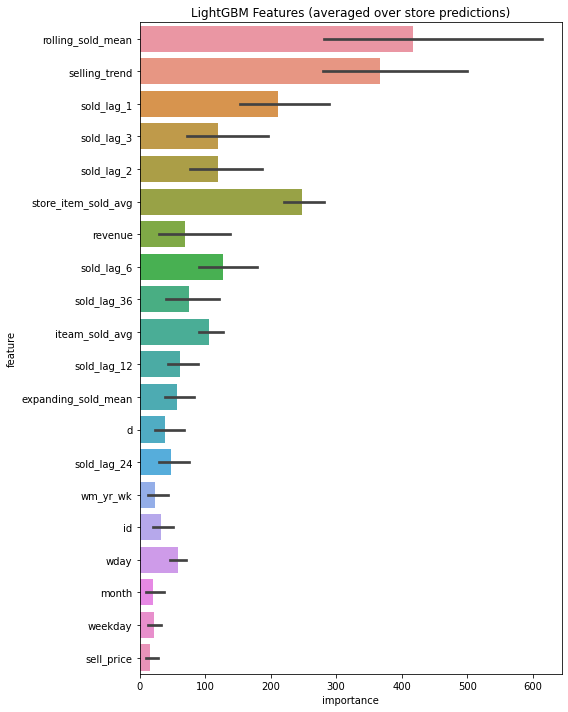

In [308]:
#Plotting feature importances
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir(path):
    if 'model' in filename:
        # load model
        model = joblib.load(path+filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)


# 7. Forecasting and submission

During feature engineering and training we had melted the provided data from wide format to long format. Now, the predictions are in long format but the format to be evaluated for the competition is in long format. Therefore, I'll convert it into wide format using pivot function in pandas (pivot function)

In [309]:
valdf=pd.read_csv(path+'sales_train_validation.csv')

In [310]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = False
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(62,90)]]
    validation['id']=valdf
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')


In [311]:
#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)
submission_file = pd.concat([validation,evaluation]).reset_index(drop=True)

In [312]:
submission_file.head(1)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [313]:
submission_file.tail(1)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
33538,HOUSEHOLD_2_516_TX_1_evaluation,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667,0.003667


################################

In [314]:
!pip install catboost

     |████████████████████████████████| 66.1MB 58kB/s 


In [315]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

- Since our dataset contains several zero values, article (https://arxiv.org/pdf/1811.10192.pdf) suggest that tweedie is the best model for non-negative data with lots of zeoros (right-skewed dataset). Therefore, tweedie objective is chosen.
- cross-validation is still laging in this notebook, which will be incorporate next notebook.

In [316]:
models=[]
results=[]
names=[]

lgb=LGBMRegressor(n_estimators=3000, # 1st place solution
                  objective='tweedie',
                  tweedie_variance_power=1.1,
                  boosting_type='gbdt',
                  learning_rate=0.015,
                  subsample=0.8,
                  colsample_bytree=0.8,
                  max_depth=8,
                  num_leaves=50,
                  min_child_weight=300
                  )

xgb=XGBRegressor(booster='gbtree',
                 tree_method='gpu_hist',
                 gpu_id=0, 
                 task_type='GPU',
                 objective='reg:tweedie',
                 eta='0.4',
                 gamma='0',
                 nrounds='20',
                 nthreads='10',
                 early_stopping_rounds='20')
ctb=CatBoostRegressor(iterations = 1500,
                      metric_period = 100,
                      #tree_method='gpu_hist',
                      task_type = "GPU",
                      devices="0:1",
                      loss_function = "RMSE",
                      eval_metric = "RMSE",
                      random_strength = 0.5,
                      depth = 7,
                      early_stopping_rounds = 100,
                      learning_rate = 0.18,
                      l2_leaf_reg = 0.1,
                      random_seed = 93)

models.append(('LGBR',lgb))
models.append(('XGBR',xgb))
models.append(('Catboost',ctb))

In [317]:
for name, model in models:
  valid = data[(data['d']>=valid_day_min) & (data['d']<valid_day_max)][['id','d','sold']]
  test = data[data['d']>=valid_day_max][['id','d','sold']]
  eval_preds = test['sold']
  valid_preds = valid['sold']

  #Get the store ids
  stores = sales.store_id.cat.codes.unique().tolist()
  for store in stores:
      df = data[data['store_id']==store]

      #Split the data
      X_train, y_train = df[df['d']<valid_day_min].drop('sold',axis=1), df[df['d']<valid_day_min]['sold']
      X_valid, y_valid = df[(df['d']>=valid_day_min) & (df['d']<valid_day_max)].drop('sold',axis=1), df[(df['d']>=valid_day_min) & (df['d']<valid_day_max)]['sold']
      X_test = df[df['d']>=valid_day_max].drop('sold',axis=1)

      print('******************************************')
      print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
      print('******************************************')
      
      model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                eval_metric='rmse', verbose=20, early_stopping_rounds=20)
      valid_preds[X_valid.index] = model.predict(X_valid)
      eval_preds[X_test.index] = model.predict(X_test)
      filename = 'model'+str(d_store_id[store])+'.pkl'
      
      #save model to specific path(location)
      #joblib.dump(model, path+filename)
      
      # del model, X_train, y_train, X_valid, y_valid
      # gc.collect()
      
      print('******************************************')
      print('***** Model for: {}  is already stored*****'.format(d_store_id[store]))
      print('******************************************')
      
      
      names.append(name)
      results.append(mean_squared_error(eval_preds, valid_preds))

      print('Validation accuracy: %s: %.3f ' %(name, mean_squared_error(eval_preds, valid_preds)))



******************************************
*****Prediction for Store: CA_1*****
******************************************
Training until validation scores don't improve for 20 rounds.
[20]	training's tweedie: 12.5735	training's rmse: 2.96366	valid_1's tweedie: 14.7051	valid_1's rmse: 2.43395
[40]	training's tweedie: 12.1921	training's rmse: 2.37798	valid_1's tweedie: 14.3793	valid_1's rmse: 1.93329
[60]	training's tweedie: 11.9777	training's rmse: 1.87701	valid_1's tweedie: 14.1961	valid_1's rmse: 1.51706
[80]	training's tweedie: 11.8335	training's rmse: 1.47	valid_1's tweedie: 14.0699	valid_1's rmse: 1.17748
[100]	training's tweedie: 11.7442	training's rmse: 1.17417	valid_1's tweedie: 13.9946	valid_1's rmse: 0.926475
[120]	training's tweedie: 11.6783	training's rmse: 0.952999	valid_1's tweedie: 13.9378	valid_1's rmse: 0.734864
[140]	training's tweedie: 11.6317	training's rmse: 0.797291	valid_1's tweedie: 13.8975	valid_1's rmse: 0.595144
[160]	training's tweedie: 11.5998	training's rm

TypeError: ignored

In [ ]:
print(names,'\n', results)

['LGBR', 'LGBR', 'LGBR', 'LGBR', 'LGBR', 'LGBR', 'LGBR', 'LGBR', 'LGBR', 'LGBR', 'XGBR', 'XGBR', 'XGBR', 'XGBR', 'XGBR', 'XGBR', 'XGBR', 'XGBR', 'XGBR', 'XGBR'] 
 [11.56432777481982, 11.43088461768884, 11.255359866281019, 11.249137712282758, 11.20529801743215, 11.12593842550663, 11.099606906873555, 11.103299712709564, 11.068373719116122, 11.011050980070292, 11.561841, 11.433936, 11.278744, 11.26946, 11.232697, 11.116749, 11.042677, 11.044509, 10.999683, 10.920682]


Since we have 10 models, each method provides the rmse result for each 10 models, where both of the methods showing similar results. 

- these results are depends on the parameters that we select. Therefore, best parameters should be choosen.

- The best parameters are can be obtained from **parameter tunning** process using some algorithm such as grid search/random search.  eg--

# Hyper-parameter tunning part is not cleaned yet !

================================================================================

In [ ]:
## Hyper Parameter tunning for xgb
n_estimators = [100, 500, 800, 1000, 1200, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

#Split the data
X_train, y_train = df[df['d']<valid_day_min].drop('sold',axis=1), df[df['d']<valid_day_min]['sold']
X_valid, y_valid = df[(df['d']>=valid_day_min) & (df['d']<valid_day_max)].drop('sold',axis=1), df[(df['d']>=valid_day_min) & (df['d']<valid_day_max)]['sold']
X_test = df[df['d']>=valid_day_max].drop('sold',axis=1)

random_cv.fit(X_train,y_train)

model=xgboost.XGBRegressor(random_cv.best_estimator_)

model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
          eval_metric='rmse', verbose=20, early_stopping_rounds=20)
valid_preds[X_valid.index] = model.predict(X_valid)
eval_preds[X_test.index] = model.predict(X_test)

# 6. Forecasting and submission
**During feature engineering and training we had melted the provided data from wide format to long format. Now, the predictions are in long format but the format to be evaluated for the competition is in long format. Therefore, I'll convert it into wide format using pivot function in pandas (pivot function)**

In [ ]:
valdf=pd.read_csv(path+'sales_train_validation.csv')
valdf_reduced=valdf.drop(valdf.iloc[:,67:1919],axis=1)#removed other data except validation (test/eval) 

In [ ]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = False
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(valid_day_min, 
valid_day_max)]]
    validation['id']=valdf_reduced
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(prediction_days)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(prediction_days)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

In [ ]:
#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(prediction_days)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)
submission_file = pd.concat([validation,evaluation]).reset_index(drop=True)


In [ ]:
submission_file.head(1)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
submission_file.tail(1)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60979,HOUSEHOLD_2_516_WI_3_evaluation,0.000008,0.000008,0.000008,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09,7.088680e-09
